In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import os
pd.options.mode.chained_assignment = None
from typing import List, Tuple

from wlcorr import EncoderDecoderStaticDataset, EncoderDecoder1DCNN
import torch
from torchsummary import summary

In [2]:
class WellCorrelationDataset:
    
    def __init__(self, 
                 root : str = '../data/',
                 train_preload : bool = True,
                 test_preload : bool = False,
                 fill_na_method : str = None):
        self.root : str = root
        self.train_path : str = os.path.join(self.root, 'train.csv')
        self.test_path : str = os.path.join(self.root, 'test.csv')
        self.train_preload : bool = train_preload
        self.test_preload : bool = test_preload
        self.fill_na_method : str = fill_na_method
        self.train_data : pd.DataFrame = None
        self.test_data : pd.DataFrame = None
        self.wells_list = None
        self.target_groups = None
        self.group_num_map = {}
        self.used_cols = ['WELL', 'Z_LOC', 'GR', 'DTC', 'GROUP']

        self.__preload__()
        
    def __preload__(self):
        if self.train_preload:
            self.train_data = pd.read_csv(self.train_path, delimiter=';')
            self.train_data.loc[:, 'Z_LOC'] *= -1
            self.train_data.sort_values(by = ['WELL', 'Z_LOC'])
            self.wells_list = self.train_data.WELL.unique()
            self.target_groups = self.train_data.GROUP.unique()
            for i, label in enumerate(self.target_groups):
                self.group_num_map.update({label : i})
            self.train_data.loc[:, 'GROUP_NUM'] = self.train_data.GROUP.map(self.group_num_map)
            self.used_cols += ['GROUP_NUM']
        
        if self.test_preload:
            self.test_preload = pd.read_csv(self.test_path, delimiter=';')
    
    def get_well(self, idx : str, process_na:bool = True):
        assert(idx in self.wells_list)
        well_df = self.train_data.loc[self.train_data.WELL == idx, self.used_cols]
        if process_na:
            if self.fill_na_method is None:
                well_df.fillna(0., inplace = True)
            else:
                assert(self.fill_na_method in ['ffill', 'bfill', 'pad'])
                well_df.fillna(method = self.fill_na_method, inplace = True)

#             well_df.dropna(inplace = True)
        return well_df
    
    def get_matching_wells_id(self, tmpt : str = ""):
        m_wells = []
        for w in self.wells_list:
            m_wells += [w] if tmpt in w else []
        return m_wells
    
    def show_wells_info(self, idx : str = ""):
        df = self.get_well(idx)
        

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EncoderDecoder1DCNN(2, 50)
model.to(device)
model.load_state_dict(torch.load('./modelstate_l2_norm'))
model.eval()

EncoderDecoder1DCNN(
  (encoder): Sequential(
    (0): Conv1d(2, 5, kernel_size=(10,), stride=(1,), padding=(9,))
    (1): SELU()
    (2): Conv1d(5, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (3): SELU()
    (4): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (5): SELU()
    (6): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=(9,))
    (7): SELU()
    (8): Conv1d(10, 1, kernel_size=(10,), stride=(1,), padding=(9,))
    (9): SELU()
    (10): Linear(in_features=145, out_features=50, bias=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(1, 5, kernel_size=(10,), stride=(1,))
    (1): SELU()
    (2): ConvTranspose1d(5, 10, kernel_size=(10,), stride=(1,))
    (3): SELU()
    (4): ConvTranspose1d(10, 10, kernel_size=(10,), stride=(1,))
    (5): SELU()
    (6): ConvTranspose1d(10, 5, kernel_size=(10,), stride=(1,))
    (7): SELU()
    (8): ConvTranspose1d(5, 5, kernel_size=(10,), stride=(1,))
    (9): SELU()
    (10): ConvTranspose1d(5, 2, kernel

In [59]:
summary(model.encoder, (2, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 5, 109]             105
              SELU-2               [-1, 5, 109]               0
            Conv1d-3              [-1, 10, 118]             510
              SELU-4              [-1, 10, 118]               0
            Conv1d-5              [-1, 10, 127]           1,010
              SELU-6              [-1, 10, 127]               0
            Conv1d-7              [-1, 10, 136]           1,010
              SELU-8              [-1, 10, 136]               0
            Conv1d-9               [-1, 1, 145]             101
             SELU-10               [-1, 1, 145]               0
           Linear-11                [-1, 1, 50]           7,300
Total params: 10,036
Trainable params: 10,036
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [3]:
dataset = WellCorrelationDataset(fill_na_method=None)

In [4]:
matching_wells = dataset.get_matching_wells_id("31")
print(f'matching wells ids : {matching_wells}')

matching wells ids : ['31/2-1', '31/2-19 S', '31/2-7', '31/2-8', '31/2-9', '31/3-1', '31/3-2', '31/3-3', '31/3-4', '31/4-10', '31/4-5', '31/5-4 S', '31/6-5', '31/6-8']


In [7]:
df_w1 = dataset.get_well('31/2-1')
df_w1

,WELL,Z_LOC,GR,DTC,GROUP,GROUP_NUM
539394,31/2-1,1140.826782,38.676811,127.922951,HORDALAND GP.,1
539395,31/2-1,1140.978760,39.491825,118.057709,HORDALAND GP.,1
539396,31/2-1,1141.130859,38.515430,112.687752,HORDALAND GP.,1
539397,31/2-1,1141.282837,37.410862,116.433235,HORDALAND GP.,1
539398,31/2-1,1141.434814,37.319504,125.814331,HORDALAND GP.,1
...,...,...,...,...,...,...
547663,31/2-1,2397.659424,38.934189,91.329124,HEGRE GP.,8
547664,31/2-1,2397.811279,37.335365,91.318741,HEGRE GP.,8
547665,31/2-1,2397.963379,36.985100,91.308357,HEGRE GP.,8
547666,31/2-1,2398.115479,36.786907,91.297974,HEGRE GP.,8


In [5]:
# for well in dataset.wells_list:
#     dataset.get_well(well, True).plot(x='Z_LOC', y=['DTC', 'GR'], kind='line', figsize=(10, 3), title=well)

<AxesSubplot:xlabel='Z_LOC'>

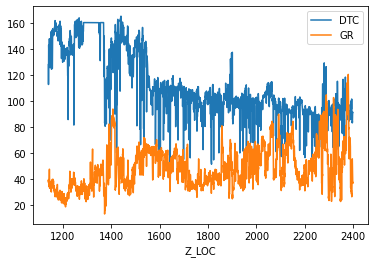

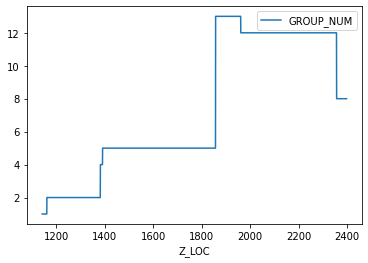

In [8]:
df_w1.plot(x = 'Z_LOC', y = ['DTC', 'GR'])
df_w1.plot(x = 'Z_LOC', y = 'GROUP_NUM')

In [9]:
group_seq = df_w1.loc[:, 'GROUP_NUM'].values
z = df_w1.loc[:, 'Z_LOC'].values

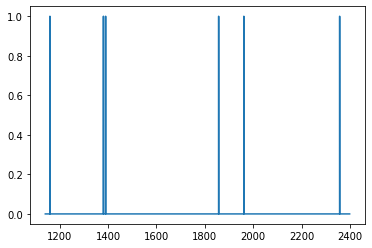

In [10]:
diff = np.zeros(group_seq.shape)
diff[1:] = group_seq[1:] - group_seq[:-1]
diff[diff != 0] = 1
plt.plot(z, diff)
plt.show()

In [11]:
def get_window(df : pd.DataFrame, 
               w_size : int = 10, 
               cols : List[str] = ['DTC', 'GR']) -> Tuple[np.ndarray, List[np.ndarray]]:
    template = []
    group_seq = df.loc[:, 'GROUP_NUM'].values
    diff = np.zeros(group_seq.shape)
    diff[1:] = group_seq[1:] - group_seq[:-1]
    idx = np.where(diff != 0)[0]
    cols = [i if col in cols else None for i, col in enumerate(df.columns) ]
    
    tmp_ = []
    for col in cols:
        if col is not None:
            tmp_ += [col]
            
    cols = tmp_
    
    for i in idx:
        w_list = np.zeros((w_size, len(cols)), dtype = np.float32)
        left_lim, right_lim = max(0, i-w_size//2), min(i+w_size//2, diff.shape[0]) 
        
        w_list = df.iloc[left_lim:right_lim, cols].values
        template += [w_list]
    
    return idx, template

In [14]:
idx, templates = get_window(df_w1, w_size=100)

In [117]:
idx

array([ 126, 1580, 1640, 4712, 5396, 8001])

In [146]:
df_w1[1575:1580]

,WELL,Z_LOC,GR,DTC,GROUP,GROUP_NUM
540969,31/2-1,1380.218872,31.195734,82.464088,ROGALAND GP.,2
540970,31/2-1,1380.370850,33.955257,87.104813,ROGALAND GP.,2
540971,31/2-1,1380.522827,36.130348,109.983986,ROGALAND GP.,2
540972,31/2-1,1380.674927,38.893509,117.153671,ROGALAND GP.,2
540973,31/2-1,1380.826904,42.070957,117.133911,ROGALAND GP.,2


In [128]:
target_template = np.float32(templates[1]).T
target_template /= np.linalg.norm(target_template, axis=1, keepdims=True)+0.000001
target_template /= np.linalg.norm(target_template, axis=0, keepdims=True)+0.000001
target_template = torch.from_numpy(target_template).unsqueeze(dim=0)
target_template = target_template.to(device)

In [70]:
model.encoder(target_template).flatten()

tensor([ 0.8053, -0.9210,  0.7079, -1.0554,  1.0868,  0.1825,  0.8354,  0.5790,
         1.3227, -0.9570, -0.4197, -0.6303,  0.0858,  0.1244,  0.2412,  0.4627,
        -0.0358, -1.3650, -0.7269, -0.0583, -0.0057,  0.3301,  0.6412, -0.1359,
         0.8542, -0.4305, -0.7535,  0.2134,  0.6381,  0.3002,  0.4011,  0.5826,
         1.0549, -0.1903,  1.2399, -0.2935,  1.1071,  0.0976,  1.2800, -0.5784,
         0.7434, -0.6245,  0.3042,  1.2193, -0.1093,  0.7513, -0.5413,  1.1055,
         1.1567, -0.8400], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)

In [113]:
def match(target_df, template, cols = [2, 3]):
    correlation_vals = []
    
    n = target_df.shape[0]
    
    feature_seq = np.float32(target_df.iloc[:, cols].values)
    feature_seq = np.pad(feature_seq, template.shape[1]//2, mode='constant', constant_values = 0)
    
#     print(template)
    template_emb = model.encoder(template).flatten()
    template_emb = template_emb.detach().cpu().numpy()
    template_emb /= np.linalg.norm(template_emb)
    
    for k in range(n-1):
        j = k + 1
        local_patch = np.float32(feature_seq[j:j + template.shape[-1], cols]).T
        local_patch /= np.linalg.norm(local_patch, axis=1, keepdims=True)+0.000001
        local_patch /= np.linalg.norm(local_patch, axis=0, keepdims=True)+0.000001
        local_patch = torch.from_numpy(local_patch).unsqueeze(dim=0)
        local_patch = local_patch.to(device)
        if (local_patch.shape != template.shape):
            continue
        local_patch_embed = model.encoder(local_patch).flatten()
        local_patch_embed = local_patch_embed.detach().cpu().numpy()
        local_patch_embed /= np.linalg.norm(local_patch_embed)
        
        correlation_vals += [template_emb.dot(local_patch_embed)]
    
    return np.array(correlation_vals, dtype=np.float32)

In [121]:
target_df = dataset.get_well(matching_wells[3])
target_df.sample(10)

,WELL,Z_LOC,GR,DTC,GROUP,GROUP_NUM
579901,31/2-8,1637.174194,83.689796,131.541733,ROGALAND GP.,2
586891,31/2-8,2702.896484,74.766411,85.959854,DUNLIN GP.,12
573863,31/2-8,719.438232,51.058136,131.743591,NORDLAND GP.,0
576815,31/2-8,1168.123047,69.409706,147.696243,HORDALAND GP.,1
579298,31/2-8,1545.527100,81.867310,123.098000,ROGALAND GP.,2
580554,31/2-8,1736.413452,58.222546,124.932816,ROGALAND GP.,2
589102,31/2-8,3042.111572,77.599373,83.370331,DUNLIN GP.,12
588167,31/2-8,2900.414551,79.229591,79.465591,DUNLIN GP.,12
590971,31/2-8,3325.324951,45.198742,74.048767,HEGRE GP.,8
576336,31/2-8,1095.320557,96.671646,142.410461,HORDALAND GP.,1


In [122]:
idx_, templates_ = get_window(target_df, w_size=100)
idx_

array([ 1918,  6233,  8733,  8819, 13391, 14713, 18328])

In [144]:
target_df[6230:6240]

,WELL,Z_LOC,GR,DTC,GROUP,GROUP_NUM
578357,31/2-8,1402.498535,61.869099,81.726646,HORDALAND GP.,1
578358,31/2-8,1402.650513,63.693352,91.836143,HORDALAND GP.,1
578359,31/2-8,1402.802612,65.927368,104.847275,HORDALAND GP.,1
578360,31/2-8,1402.954590,65.323738,113.539238,ROGALAND GP.,2
578361,31/2-8,1403.106567,67.407516,120.848610,ROGALAND GP.,2
578362,31/2-8,1403.258545,68.693100,128.372070,ROGALAND GP.,2
578363,31/2-8,1403.410522,70.080910,132.199631,ROGALAND GP.,2
578364,31/2-8,1403.562622,74.792679,132.872070,ROGALAND GP.,2
578365,31/2-8,1403.714600,80.220810,134.035065,ROGALAND GP.,2
578366,31/2-8,1403.866455,80.311028,137.685333,ROGALAND GP.,2


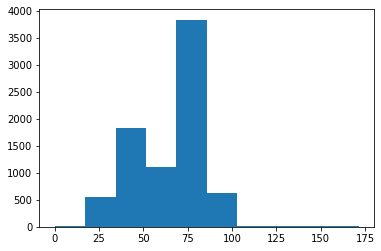

In [103]:
plt.hist(np.pad(target_df.iloc[:, 2].values, 5, mode='constant', constant_values = 0))
plt.show()

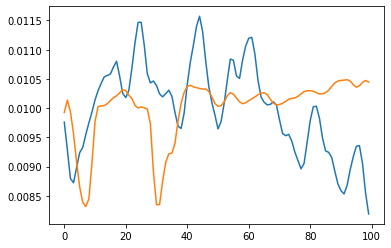

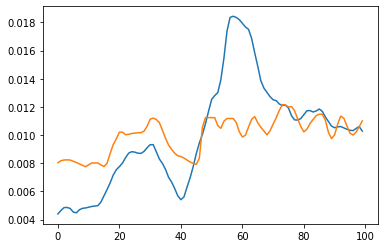

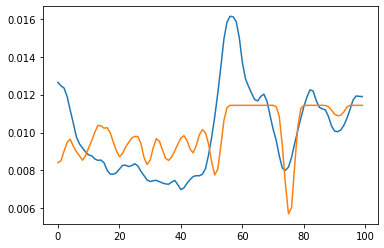

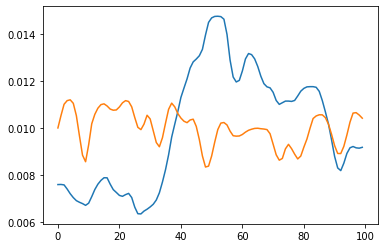

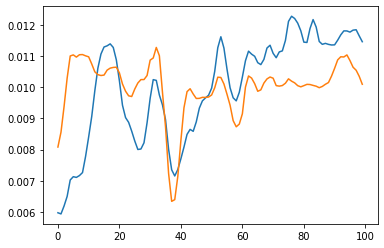

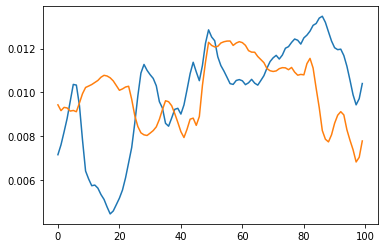

In [104]:
for template in templates:
    plt.plot(template/np.sum(template, axis = 0))
    plt.show()

In [129]:
# for template in templates:
#     correlation_vals = match(target_df, target_template).T
# #     print(correlation_vals)
# #     break
# #     correlation_vals = np.mean(correlation_vals, axis=1)
#     plt.plot(target_df.Z_LOC.values, correlation_vals)
#     plt.show()

In [130]:
correlation_vals = match(target_df, target_template)

In [143]:
np.argmax(correlation_vals)

6198

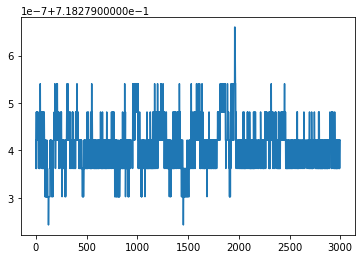

In [140]:
plt.plot(correlation_vals[:3000])
plt.show()

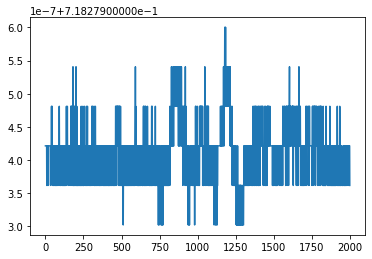

In [141]:
plt.plot(correlation_vals[3000:5000])
plt.show()

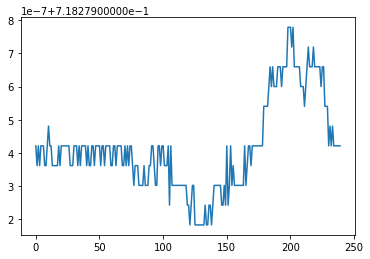

In [149]:
plt.plot(correlation_vals[6000:6240])
plt.show()

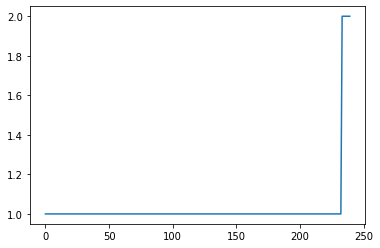

In [152]:
plt.plot(target_df[6000:6240].GROUP_NUM.values)
plt.show()

In [135]:
np.unique(correlation_vals)

array([0.5443754 , 0.5463704 , 0.54932016, 0.55244344, 0.5564037 ,
       0.5608621 , 0.5659883 , 0.57126963, 0.57665753, 0.582036  ,
       0.58776224, 0.592853  , 0.5980824 , 0.60273385, 0.60728174,
       0.61141866, 0.61533964, 0.6188596 , 0.6223005 , 0.62508523,
       0.6280308 , 0.63067025, 0.6329458 , 0.6354452 , 0.6377692 ,
       0.63972306, 0.641431  , 0.64340186, 0.6451144 , 0.6464665 ,
       0.6483348 , 0.65011066, 0.6517459 , 0.65397614, 0.6561806 ,
       0.6585884 , 0.66106284, 0.6639206 , 0.6670915 , 0.6700411 ,
       0.67291874, 0.6763302 , 0.67953414, 0.68265575, 0.6856237 ,
       0.68886095, 0.6921556 , 0.6950395 , 0.69833905, 0.7014113 ,
       0.70485896, 0.7082317 , 0.71155274, 0.7146248 , 0.7182791 ,
       0.7182792 , 0.71827924, 0.7182793 , 0.71827936, 0.7182794 ,
       0.7182795 , 0.71827954, 0.7182796 , 0.71827966, 0.7182797 ,
       0.7182798 ], dtype=float32)

In [43]:
group_seq = target_df.loc[:, 'GROUP_NUM'].values
z = target_df.loc[:, 'Z_LOC'].values

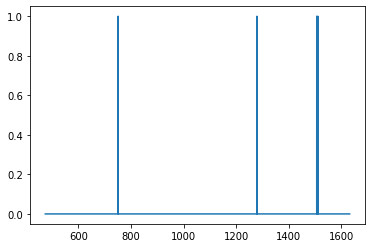

In [44]:
diff = np.zeros(group_seq.shape)
diff[1:] = group_seq[1:] - group_seq[:-1]
diff[diff != 0] = 1
plt.plot(z, diff)
plt.show()

In [45]:
target_df.isna().all()

WELL         False
Z_LOC        False
GR           False
DTC          False
GROUP        False
GROUP_NUM    False
dtype: bool